In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.integrate import cumtrapz
from scipy.signal import savgol_filter
import sys, os, pickle
from autophasemap import plot_clusters
color_blindf = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", 
"#a96b59", "#e76300", "#b9ac70", "#92dadd"]
bkg_spectra_color = "#717581"

In [3]:
plt_style = {"text.usetex": True,
             "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
             "axes.spines.right" : False,
             "axes.spines.top" : False,
             "font.size": 22,
             "savefig.dpi": 600,
             "savefig.bbox": 'tight'
            }

In [4]:
with open('./data_smooth6.pkl', 'rb') as f:
    result = pickle.load(f)
    
n_clusters = 6

In [5]:
class DataSet:
    def __init__(self, C, q, Iq, N, n_domain=200):
        """ Dataset object for autophasemap with SAXS.

        Parameters:
        ===========
        C : numpy array of shape (N, dim)
            Cartesian coordinates of the design space
        q : numpy array of shape (n_domain, )
            q-vector sampling 
        Iq : numpy array of shape (N, n_domain)
            Intensity as a function of q
        N : int
            Number of samples 
        n_domain : int
            Number of discrete samples of the domain q      
        """
        self.n_domain = n_domain
        self.t = np.linspace(0,1, num=self.n_domain)
        self.N = N
        self.Iq = Iq
        self.C = C
        self.q = q
        
    def generate(self, process=None):
        """ Generate the data into an acceptable form by autophasemap.

        Parameters:
        ===========
        process : string
            "normalize" : Normalizes each function to have L2 norm=1
            "smoothen" : Normalize and smoothen each function
            None : Use the data as is
     
        """
        
        if process=="normalize":
            self.F = [self.Iq[i]/self.l2norm(self.Iq[i]) for i in range(self.N)]
        elif process=="smoothen":
            self.F = [self._smoothen(self.Iq[i,:]/self.l2norm(self.Iq[i])) for i in range(self.N)]
        elif process is None:
            self.F = [self.Iq[i] for i in range(self.N)]
            
        return
        
    def l2norm(self, f):
        """ Compute L2 norm of a function.

        Parameters:
        ===========
        f : numpy array of shape (n_domain, )
            Discrete evaluation of function at the domain q
        
        Return:
        ======
        norm : float
            L2 norm of the function       
        
        """
        norm = np.sqrt(np.trapz(f**2, data.t))
        
        return norm
    
    def _smoothen(self, f):
        f_hat = savgol_filter(f, 8, 3)
        
        return f_hat
    
saxs = np.load('../../expts/OMIECS/blends_WSCP_P123_NOpH.npz')

q = saxs['q']
n_domain = len(saxs['q'])

C = saxs['C']
Iq = saxs['Iq']

N = C.shape[0]

data = DataSet(C, q, Iq, N, n_domain=n_domain)
data.generate(process="smoothen")
print('Number of functions : ', data.N)
print('Domain sampling of each function : ', n_domain)

Number of functions :  93
Domain sampling of each function :  1304


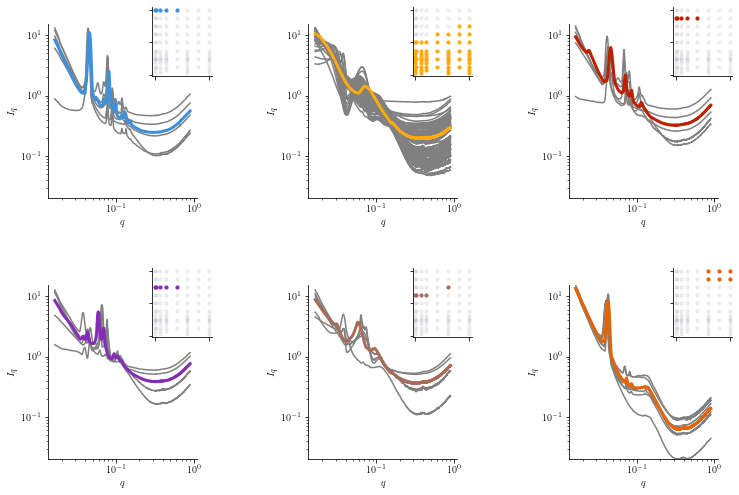

In [6]:
with plt.style.context(plt_style):
    fig, axs = plt.subplots(2,3, figsize=(4*3, 4*2))
    fig.subplots_adjust(wspace=0.75, hspace=0.5)
    axs = axs.flatten()
    plot_clusters(axs, data, result, mode='input')
    plt.show()

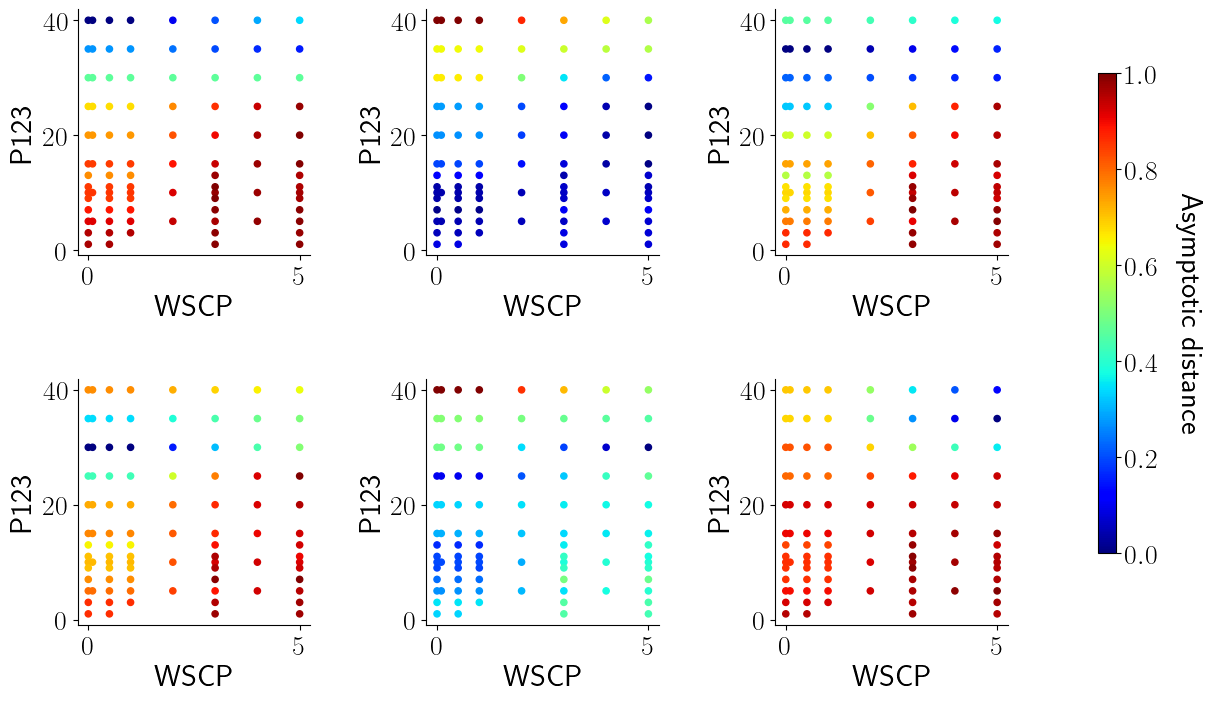

In [7]:
with plt.style.context(plt_style):
    fig, axs = plt.subplots(2,3, figsize=(4*3, 4*2))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    axs = axs.flatten()
    for k, ax in enumerate(axs):
        cmap = cm.get_cmap('jet')
        ax.scatter(data.C[:,0], 
                   data.C[:,1],
                   c = result['dist'][:,k],
                   cmap=cmap,
                   s=20
                  )
        ax.set_xlabel(saxs['C_dim_names'][0], fontsize=22)
        ax.set_ylabel(saxs['C_dim_names'][1], fontsize=22)
        ax.tick_params(labelsize=20)

    norm = Normalize(vmin=0, vmax = 1)
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = plt.axes([0.975, 0.2, 0.015, 0.6])        
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.set_ylabel(r'Asymptotic distance', rotation=270, labelpad=32)
    plt.show()